In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

2024-05-24 08:13:37.445924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 08:13:37.446022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 08:13:37.705292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Importing all the necessary libraries
* TensorFlow
* Keras 

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


 * The (X_train, y_train) tuple represents the training data
 * X_train contains the input images
 * y_train contains the corresponding labels
 * (X_test, y_test) contains the test data

In [4]:
# We will use 10% of the training data as a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [5]:
print('Train Images Shape:      ', x_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', x_val.shape)
print('Validation Labels Shape: ', y_val.shape)

print('\nTest Images Shape:       ', x_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (40500, 32, 32, 3)
Train Labels Shape:       (40500, 1)

Validation Images Shape:  (4500, 32, 32, 3)
Validation Labels Shape:  (4500, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


* X_train and y_train for training the model
* X_valid and y_valid for validation
1. A validation set is crucial for tuning the model's hyperparameters and preventing overfitting.
2. It allows us to evaluate the model's performance on unseen data during training and helps in model selection.

In [6]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               


In [14]:
print(type(x_test))

<class 'numpy.ndarray'>


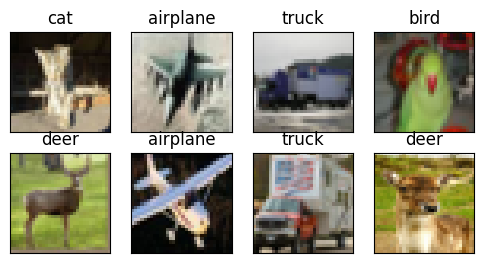

In [9]:
    
# Create a new figure
plt.figure(figsize=(6,6))

# Loop over the first 15 images
for i in range(8):
    # Create a subplot for each image
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(x_train[i])

    # Set the label as the title
    plt.title(class_names[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

**Exploratory Data Analysis**
1. Normalization of Image Data
    * Normalize pixel values to a common scale
    * Divide each pixel value by 255 (the maximum pixel intensity) to achieve this normalization
    * Normalization helps the neural network converge faster during training
    
2. One-Hot Encoding of Labels
    * Convert class labels (e.g., “airplane,” “bird,” etc.) into numerical representations.
    * One-hot encoding assigns a unique binary vector to each class label
    * For example, if an image belongs to the “bird” class, its label vector would be [0, 0, 1, 0, …] (with a 1 at the bird index)
    
3. Data Augmentation
    * Augment the training dataset by applying transformations to the images.
    * Common augmentations include rotation, translation, flipping, and zooming.
    * Data augmentation increases the effective size of your training data and improves model generalization.

**Normalization of Image Data**

Convert the data type of the pixel values from their original integer type (typically uint8) to float32. This is necessary because most deep learning frameworks perform better with floating-point computations. Additionally, it prepares the data for normalization.

In [11]:
# Convert pixel values data type to float32
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_val = x_val.astype('float32')

# Calculate the mean and standard deviation of the training images

mean = np.mean(x_train) #Compute the mean pixel value across the entire training dataset. This gives us a single mean value that represents the average brightness of all training images.
std  = np.std(x_train) #Compute the standard deviation of the pixel values across the entire training dataset. This measures the amount of variation or dispersion from the mean.

# Normalize the data
# The tiny value 1e-7 is added to the denominator to prevent division by zero, which can occur if the standard deviation is extremely small.
x_train = (x_train-mean)/(std+1e-7)
x_test  = (x_test-mean) /(std+1e-7)
x_val = (x_val-mean)/(std+1e-7)

# normalization process is applied to the test and validation sets using the mean and standard deviation computed from the training set. This ensures that all datasets are normalized consistently.

**One-Hot Encoding of Labels**

In [12]:
# Convert labels to one-hot encoding using to_categorical() function. note that the images are in 10 class types
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test  = to_categorical(y_test, 10)

**Data Augmentation**

In [13]:
# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)

**Define CNN Model Architecture**

we will use a Convolutional Neural Network (CNN) which is well-suited for image recognition tasks

1. Activation Function
    * We use the ReLU (Rectified Linear Unit) activation function in the convolutional layers.
    * ReLU is computationally efficient and helps in mitigating the vanishing gradient problem.
2. Loss Function
    * For multi-class classification, we use the categorical cross-entropy loss function

In [14]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

**Model Architecture Design Strategy**
1. Regularization
To avoid overfitting, we have used dropout layers in the dense part of the network.

2. Batch Normalization
Although not used in the initial implementation, batch normalization could be added to further stabilize and accelerate the training

3. Data Augmentation
In practice, data augmentation techniques like random flips, rotations, and shifts has been employed to artificially increase the size of the training dataset

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

**Training the CNN Model**

**Loss Function**
 * For multi-class classification, we use the categorical cross-entropy loss function

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


**Training the Model**
* We will train the model for 250 epochs.

In [17]:
epochs = 250

In [18]:
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=64)

Epoch 1/250
 55/633 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1762 - loss: 2.2079

I0000 00:00:1716456196.730250     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716456196.747652     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3265 - loss: 1.8219

W0000 00:00:1716456201.446783     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716456202.462188     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


633/633 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3266 - loss: 1.8216 - val_accuracy: 0.5471 - val_loss: 1.2640
Epoch 2/250
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5518 - loss: 1.2649 - val_accuracy: 0.6276 - val_loss: 1.0597
Epoch 3/250
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6245 - loss: 1.0716 - val_accuracy: 0.6646 - val_loss: 0.9652
Epoch 4/250
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6712 - loss: 0.9463 - val_accuracy: 0.6875 - val_loss: 0.9048
Epoch 5/250
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7103 - loss: 0.8362 - val_accuracy: 0.6921 - val_loss: 0.8810
Epoch 6/250
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7414 - loss: 0.7550 - val_accuracy: 0.6974 - val_loss: 0.8780
Epoch 7/250
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7574 - loss: 0.7050 - val_accuracy: 0.7131 - val_loss: 0.8409
Epoch 8/250
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7799 - loss: 0.6347 - val_accuracy: 0.72

In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7085 - loss: 4.6141
Test accuracy: 0.704800009727478


**Performance Evaluation**

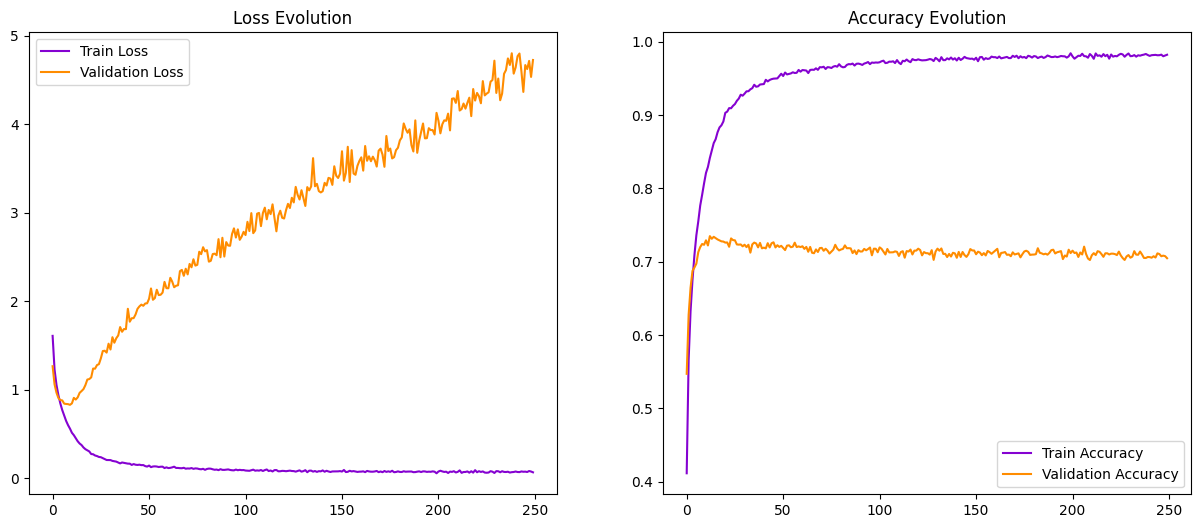

In [20]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [ ]:
# Fetch the raw image from GitHub
url = "https://raw.githubusercontent.com/FarzadNekouee/Keras-CIFAR10-CNN-Model/master/truck_sample.png"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
# Display the image
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [ ]:
# Resize it to 32x32 pixels
image = cv2.resize(image, (32,32))

# Normalize the image
image = (image-mean)/(std+1e-7)

# Add an extra dimension because the model expects a batch of images
image = image.reshape((1, 32, 32, 3))

In [ ]:
prediction = model.predict(image)

In [ ]:
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

In [ ]:
# Checking the predictions! (Hidden Input)
predictions = model.predict(x_test)

plt.figure(figsize=[10,10])

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.subplot(2,2,1)
n = 1
plt.imshow(x_test[n].reshape(32, 32, -1), cmap=plt.cm.binary)
plt.title("Predicted value: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.subplot(2,2,2)
n = 3
plt.imshow(x_test[n].reshape(32, 32, -1), cmap=plt.cm.binary)
plt.title("Predicted value: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.subplot(2,2,3)
n = 5
plt.imshow(x_test[n].reshape(32, 32, -1), cmap=plt.cm.binary)
plt.title("Predicted value: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.subplot(2,2,4)
n = 30
plt.imshow(x_test[n].reshape(32, 32, -1), cmap=plt.cm.binary)
plt.title("Predicted value: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.suptitle("Predictions of CIFAR-10 Data", size=30, color="#6166B3")

plt.show()

In [ ]:
# Model  2 optimization
batch_size = 64

# Set the maximum number of epochs for the training
epochs = 300

# Define the optimizer (Adam)
optimizer = Adam(learning_rate=0.0005)

# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Add EarlyStopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 40 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# Fit the model on the training data, using the defined batch size and number of epochs
# The validation data is used to evaluate the model's performance during training
# The callbacks implemented are learning rate reduction when a plateau is reached in validation loss and
# stopping training early if no improvement is observed
model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[reduce_lr, early_stopping], 
          verbose=2)

**Visualizing the Learning Curves**

In [4]:
# model 2 with Batch Normalization
model = Sequential()
model.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,517,450 (5.79 MB)

 Trainable params: 1,515,658 (5.78 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [26]:
# Define early stopping callback
# Here, training will be stopped if no improvement in validation loss is observed for 20 epochs.
# The `restore_best_weights` parameter ensures that the model weights are reset to the values from the epoch
# with the best value of the monitored quantity (in this case, 'val_loss').
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Add ReduceLROnPlateau callback
# Here, the learning rate will be reduced by half (factor=0.5) if no improvement in validation loss is observed for 10 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)


# Fit the model with early stopping
history = model.fit(x_train, y_train, epochs=100, verbose=1, 
                    validation_data=(x_test, y_test), callbacks=[early_stopping,reduce_lr])

Epoch 1/100
   7/1266 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.0560 - loss: 3.8515     

W0000 00:00:1716457323.471080     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3395 - loss: 2.0738

W0000 00:00:1716457353.094062     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716457354.552990     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1266/1266 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - accuracy: 0.3396 - loss: 2.0735 - val_accuracy: 0.5792 - val_loss: 1.1732
Epoch 2/100
   9/1266 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.6006 - loss: 1.1062

W0000 00:00:1716457357.588537     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1266/1266 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6105 - loss: 1.0913 - val_accuracy: 0.6934 - val_loss: 0.8758
Epoch 3/100
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7070 - loss: 0.8352 - val_accuracy: 0.7310 - val_loss: 0.7738
Epoch 4/100
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7574 - loss: 0.6985 - val_accuracy: 0.7485 - val_loss: 0.7478
Epoch 5/100
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7943 - loss: 0.6021 - val_accuracy: 0.8116 - val_loss: 0.5604
Epoch 6/100
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8205 - loss: 0.5221 - val_accuracy: 0.8230 - val_loss: 0.5319
Epoch 7/100
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8440 - loss: 0.4552 - val_accuracy: 0.8238 - val_loss: 0.5283
Epoch 8/100
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8663 - loss: 0.3909 - val_accuracy: 0.8099 - val_loss: 0.5802
Epoch 9/100
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8831 - los

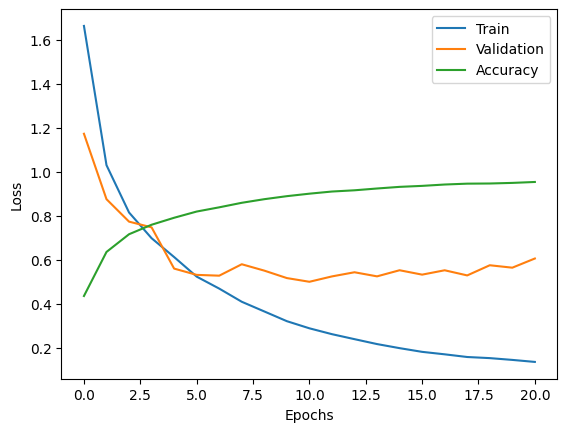

In [27]:
def plotloss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation', 'Accuracy'])
    plt.show()    
plotloss(history)

In [29]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8527 - loss: 0.5833
Test accuracy: 0.8464999794960022


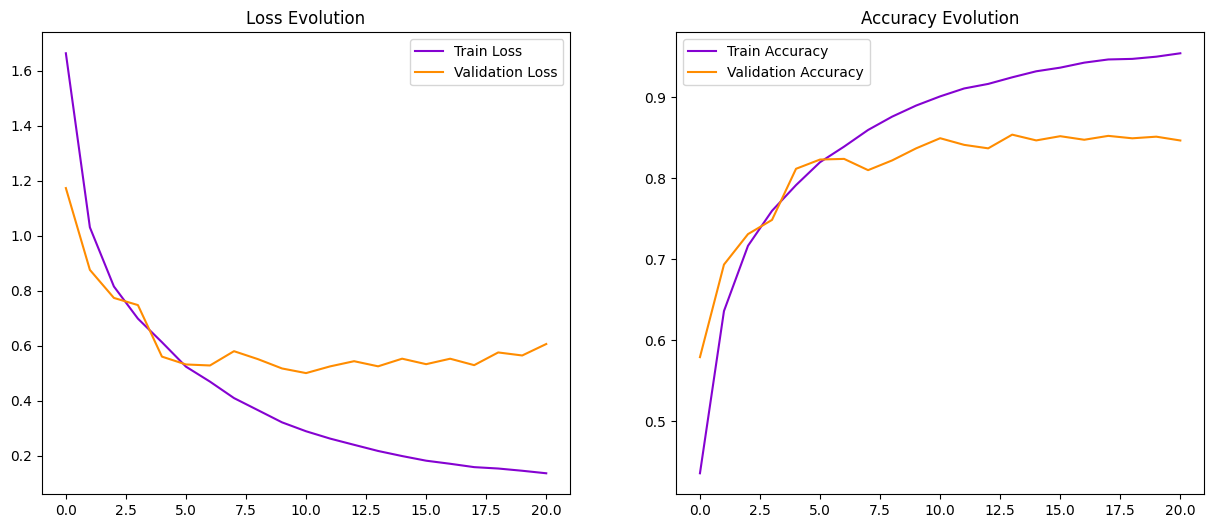

In [28]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

**Interpretation**
1. Test Accuracy: The test accuracy of approximately 0.8465 (or 84.65%) indicates that the model correctly classified around 84.65% of the test images.
2. Loss Value: The test loss of 0.5833 indicates the difference between the predicted values and the actual values for the test data. Lower loss generally indicates better model performance.
**Summary**
   * After optimising the first model, Model_2 performed better on the neural network on the test dataset and had the highest accuracy. The test accuracy of around 84.65% compared to 70% from the first model. This suggests that the model performs reasonably well on the CIFAR-10 unseen data, though there may be room for further optimization and improvement.